<a href="https://colab.research.google.com/github/rfrod/bbuy_assignment/blob/main/BestBuy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best Buy assignment

## Ecommerce Analytics – Data Scientist

### Business Problem
Inventory management is an important task at Best Buy: we need to order enough stock to satisfy
customer demand while minimizing wasted warehouse space. With thousands of products
available to buy at any given time, it can be difficult to create an accurate forecast for every
product.
As our new Data Scientist, the Vice President of Inventory asks you to help:
> *“We need to understand how much inventory we need to buy for each of these key products.
Can you build a model that provides guidance to our inventory analysts? Once you are done
please build a presentation that explains your proof of concept to other executives in the
company”*

## Import data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/data.xlsx')

## Data exploration

In [3]:
data.head()

,week,product,orders,brand,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,Big Cable Brand,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0


### Statistics

First lets start with the data info and description.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       260 non-null    object 
 1   product    260 non-null    object 
 2   orders     259 non-null    float64
 3   brand      260 non-null    object 
 4   views      259 non-null    float64
 5   cart_adds  259 non-null    float64
 6   price      259 non-null    float64
 7   inventory  260 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 16.4+ KB


There is at list **one row with null value** for *orders*, *views*, *cart_adds* and *price* columns.

In [5]:
data.describe()

,orders,views,cart_adds,price,inventory
count,259.000000,259.000000,259.000000,259.000000,260.000000
mean,19.413127,2156.447876,50.111969,69.951390,80.057692
std,14.731024,1952.060224,49.124101,61.324199,49.346859
min,0.000000,39.000000,0.000000,19.990000,0.000000
25%,7.000000,587.000000,16.000000,34.990000,50.750000
50%,16.000000,1466.000000,37.000000,49.990000,70.000000
75%,30.000000,3203.000000,67.000000,82.490000,94.250000
max,100.000000,9138.000000,309.000000,524.990000,308.000000


It looks like we have at least one line without *order*,*cart_adds*, and *inventory*. We don't have any absurd value in the fields like negative orders or huge values.

In [6]:
data['product'].value_counts()

A    52
B    52
C    52
D    52
E    52
Name: product, dtype: int64

**52 weeks** from each product equals an **year**. The data seems weel distributed between the products.

In [7]:
data['brand'].value_counts()

Little Cable Brand    156
Big Cable Brand       104
Name: brand, dtype: int64

No extraordinary thing about the brands until now. Let's check the correlation between the numerical features.

In [8]:
df_corr = data[['week','orders','views','cart_adds','price']]
df_corr.corr()

,orders,views,cart_adds,price
orders,1.000000,0.649754,0.786845,-0.539329
views,0.649754,1.000000,0.521902,-0.469849
cart_adds,0.786845,0.521902,1.000000,-0.422136
price,-0.539329,-0.469849,-0.422136,1.000000


As expected the price has **inverse** correlation with *orders*, *views* and *cart_adds*, and *cart_adds* are more strongly correlated with *orders* than *views*.

In [9]:
df_1 = data.groupby(['product'])['orders','views','cart_adds'].sum()
df_1 = df_1[['views','cart_adds','orders']]
df_1.sort_values(['views','cart_adds','orders'], ascending=[False,False,False]).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,views,cart_adds,orders
product,,,
D,166323.0,3708.0,1304.0
A,166165.0,3775.0,1556.0
C,146267.0,3438.0,1367.0
E,44826.0,1223.0,450.0
B,34939.0,835.0,351.0


It looks like there is something strange with product **D**. It is supposed to exist some proportion in the conversion rate between *view*, *cart_adds* and *orders*.

### Inventory

In [10]:
df_2 = data[['week','product','inventory']]
df_2.loc[df_2['inventory'] == 0]['product'].value_counts()

D    7
A    6
Name: product, dtype: int64

We are having inventory problems in products D and A.

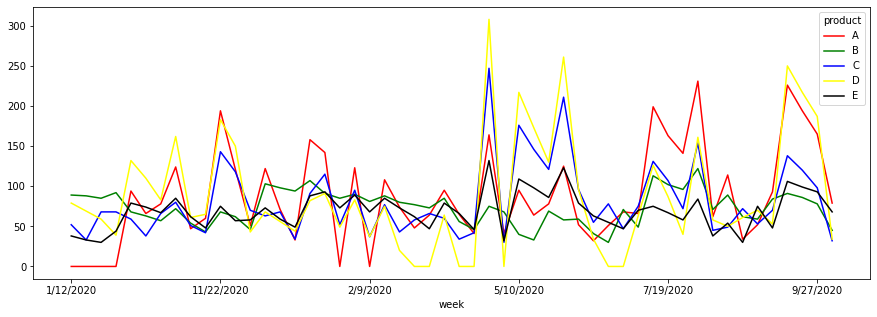

In [11]:
df_2 = df_2.pivot(index='week',columns='product', values='inventory')
_ = df_2.plot(color=['red','green','blue','yellow','black'], figsize=(15, 5))

Product **A** seems not to be comercialized at the beginning of the serie.

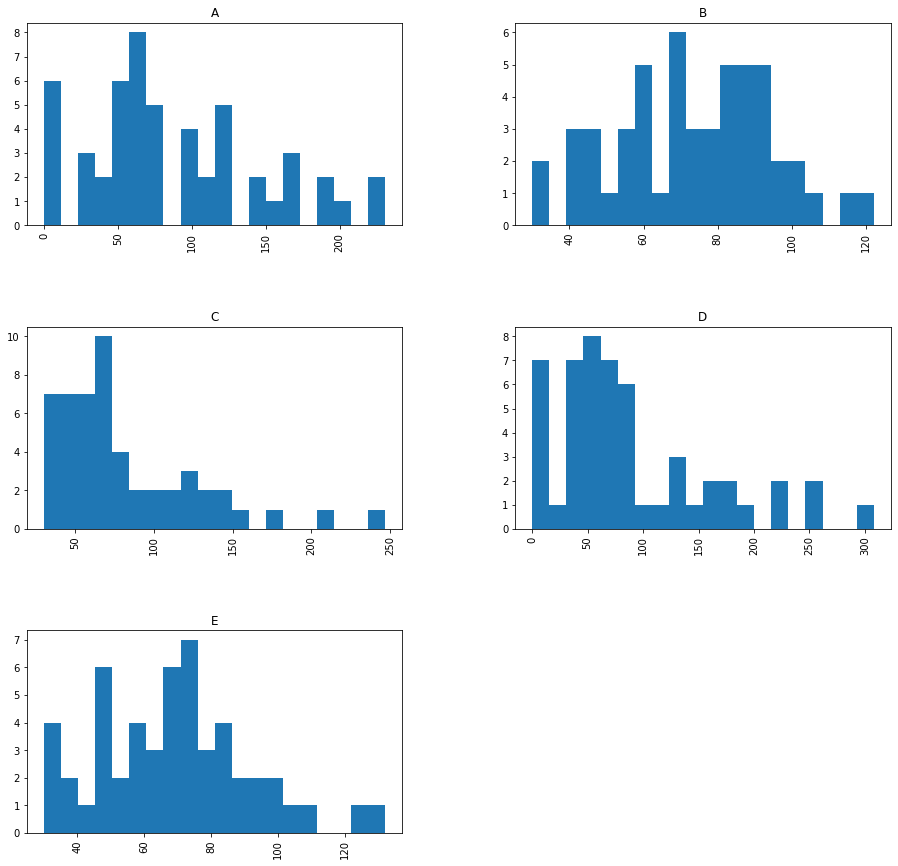

In [12]:
_ = data.hist(column='inventory', by='product', figsize=(15, 15), bins=20)

### Orders

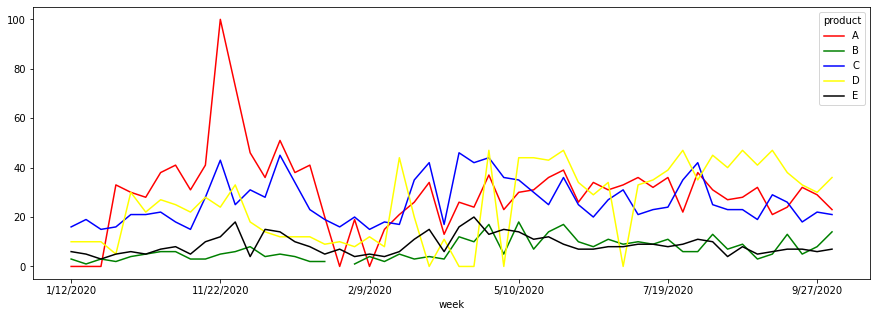

In [13]:
df_3 = data[['week','product','orders']]
df_3 = df_3.pivot(index='week',columns='product', values='orders')
_ = df_3.plot(color=['red','green','blue','yellow','black'], figsize=(15, 5))

We can see that there is some data missing for product **B**.

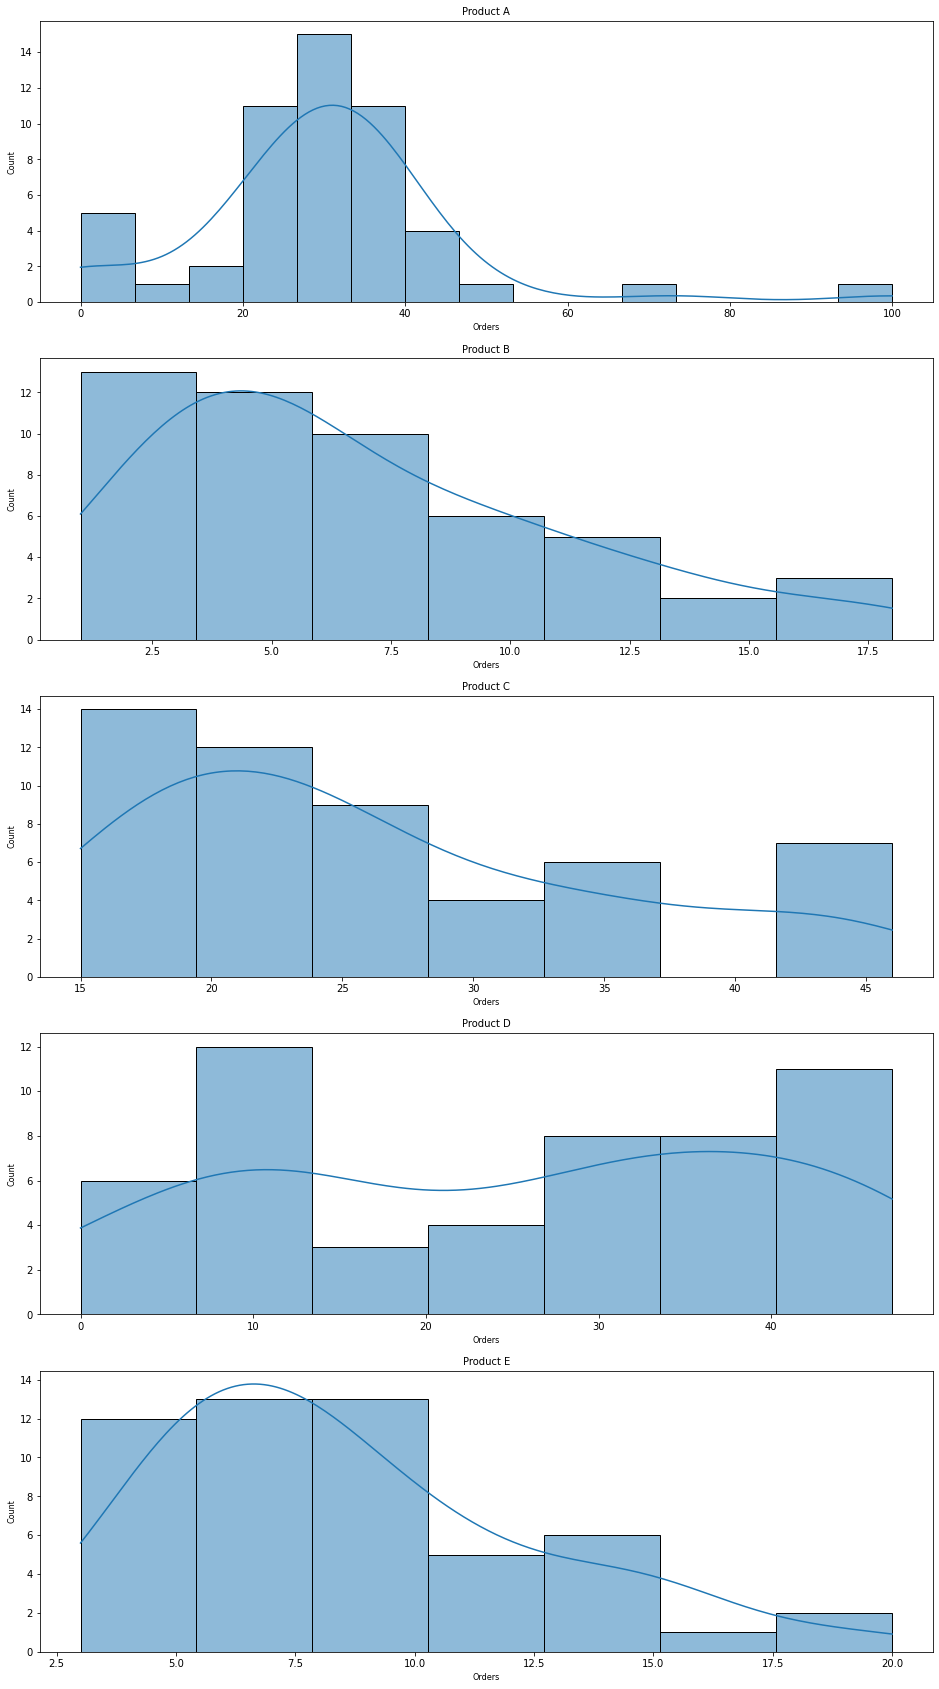

In [14]:
df_3 = data[['week','product','orders']]
prods = df_3['product'].unique()
fig, ax = plt.subplots(len(prods), figsize=(16,30))

for i, prod in enumerate(prods):
        
    sns.histplot(data=df_3.loc[df_3['product']==prod]['orders'], kde=True, ax=ax[i])
    ax[i].set_title('Product '+prod, fontsize=10)
    ax[i].set_xlabel('Orders', fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.show()

Except for the product **D**, all other product looks like having a log-normal distribution.

In [15]:
products_stat =data.groupby('product')['orders'].describe().reset_index()
print(products_stat)

  product  count       mean        std   min    25%   50%    75%    max
0       A   52.0  29.923077  16.590626   0.0  23.00  31.0  36.00  100.0
1       B   51.0   6.882353   4.361867   1.0   3.50   6.0   9.50   18.0
2       C   52.0  26.288462   9.010531  15.0  19.00  23.5  31.75   46.0
3       D   52.0  25.076923  15.448645   0.0  10.75  27.5  38.25   47.0
4       E   52.0   8.653846   3.930198   3.0   6.00   8.0  11.00   20.0


Looks like the high **standard deviation** on products *A* and *D* may explain why they get out of stock, and we can also confirm the missing data for product **B**.

Now, lets check the outliers.

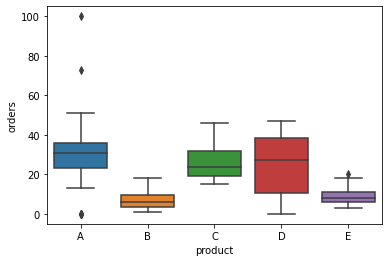

In [16]:
ax = sns.boxplot(x="product", y="orders", data=data)

Product **A** have some outliers on its orders.

### Price

Now, based on *price* let's check the revenue for each product.

In [20]:
dt_price = data[['week','product','orders','price']].copy()
dt_price['revenue'] = dt_price['orders'] * dt_price['price']

In [48]:
dt_revenue = dt_price.groupby('product')['revenue'].agg('sum')
mylabels = ['A','B','C','D','E']
explode = (0, 0, 0.2, 0, 0)



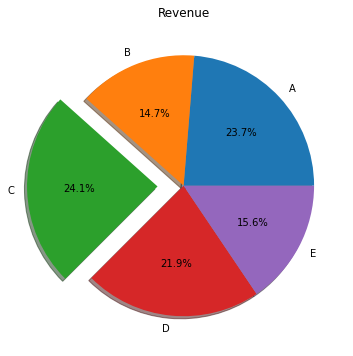

In [53]:
fig1, ax1 = plt.subplots(figsize=(6, 6))
plt.pie(dt_revenue,labels=mylabels,explode = explode, autopct='%1.1f%%', shadow = True)
plt.title('Revenue')
plt.show()

## Approach 1: Using machine Learning regression model

### Step 1: Data Selection and Cleaning


#### Select columns
Removed the columns inventory 

In [17]:
dt = data[['week','product','orders','views','cart_adds','price']]

#### Filling NA values

We are going to fill the Nan values of the B product with the mean of the fields for its specific product.

In [18]:
df_prod_means = dt.groupby(['product'])['orders','views','cart_adds','price'].agg('mean').copy()
df_prod_means.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,orders,views,cart_adds,price
product,,,,
A,29.923077,3195.480769,72.596154,36.240000
B,6.882353,685.078431,16.372549,138.519412
C,26.288462,2812.826923,66.115385,42.105385
D,25.076923,3198.519231,71.307692,44.605385
E,8.653846,862.038462,23.519231,89.605385


In [19]:
dt.loc[(dt['orders'].isnull()) & (dt['product'] == 'B'), ['orders']] = round(df_prod_means.orders['B'],0)
dt.loc[(dt['views'].isnull()) & (dt['product'] == 'B'), ['views']] = round(df_prod_means.views['B'],0)
dt.loc[(dt['cart_adds'].isnull()) & (dt['product'] == 'B'), ['cart_adds']] = round(df_prod_means.cart_adds['B'],0)
dt.loc[(dt['price'].isnull()) & (dt['product'] == 'B'), ['price']] = round(df_prod_means.price['B'],2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Building training data

We will use the previous week data and the current week price for predicting the current week sales.

Here is the function for building the training data.

In [20]:
def def_conjXY(df,interval, column_idx = 0):
    """
    :df = Dataframe with the data; 
    :interval = number of days to make a forecast
    :column_idx = index fo the columns used at the forecast
    :Returns: X and Y
    """
    input_value = []
    output_value = []
    if type(df) == pd.core.frame.DataFrame:
        for i in range(interval,(len(df))):
            x = np.array(df.iloc[i-interval: i, [0,1,2,3,4,5]])
            x = np.append(x, df.iloc[i,5])
            y = np.array(df.iloc[i, 2])    
            input_value.append(x)
            output_value.append(y)
    else:
        for i in range(interval,(len(df))):
            x = np.array(df[i-interval: i, [0,1,2,3]])
            y = np.array(df[i, item])    
    input_value.append(x)
    output_value.append(y)
    x_train = np.array(input_value)
    y_train = np.array(output_value)
    #x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    return x_train , y_train

In [21]:
X,y = def_conjXY(dt,1)

In [22]:
X_dt = pd.DataFrame(X, columns=['week','product','orders','views','cart_adds','price','next_price'])
X_dt['orders'] = X_dt['orders'].apply(int)
X_dt['views'] = X_dt['views'].apply(int)
X_dt['cart_adds'] = X_dt['cart_adds'].apply(int)
X_dt['price'] = X_dt['price'].apply(float)
X_dt['next_price'] = X_dt['next_price'].apply(float)
X_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   week        260 non-null    object 
 1   product     260 non-null    object 
 2   orders      260 non-null    int64  
 3   views       260 non-null    int64  
 4   cart_adds   260 non-null    int64  
 5   price       260 non-null    float64
 6   next_price  260 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 14.3+ KB


In [23]:
y_dt = pd.DataFrame(y, columns=['next_order'])
y_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   next_order  260 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


### Step 2: Encodind and Scaling

Another good approach is to One Hot encode the categorical data (*product*) and reduce the scale of the numerical data.

In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore",sparse=False)
#one_hot = OneHotEncoder(sparse=False)
one_hot_tr = encoder.fit_transform(X_dt[['product']])
#scaler = StandardScaler()
#encoder.fit(X_dt[['product']])

In [25]:
from sklearn.preprocessing import StandardScaler

attr_for_scaling = ['orders','views','cart_adds','price','next_price']
scaler = StandardScaler()
scale_tr = scaler.fit_transform(X_dt[attr_for_scaling])

target_scaler = StandardScaler()
y_s = target_scaler.fit_transform(y_dt)

In [28]:
#X_dt2 = encoder.transform(X_dt[['product']])
#X_dt2 = pd.DataFrame(X_dt2.toarray())
#X_dt3 = X_dt.join(X_dt2)
data_prepared = np.concatenate((one_hot_tr, scale_tr), axis=1)

features = list(['A','B','C','D','E']) + attr_for_scaling
X_dt4 = pd.DataFrame(data_prepared,
                     columns=features,
                     index = X_dt.index)

#X_dt4 = X_dt3.drop(columns=['week','product'])
X_dt4.head()
X_dt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   A           260 non-null    float64
 1   B           260 non-null    float64
 2   C           260 non-null    float64
 3   D           260 non-null    float64
 4   E           260 non-null    float64
 5   orders      260 non-null    float64
 6   views       260 non-null    float64
 7   cart_adds   260 non-null    float64
 8   price       260 non-null    float64
 9   next_price  260 non-null    float64
dtypes: float64(10)
memory usage: 20.4 KB


### Setp 3: Split train test data

In [29]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dt4, y_s,
                                                  test_size = .2,
                                                  random_state=12)

### Step 4: Train the model

We will evaluate 2 models: XGBboost and Linear regression.

In [31]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', booster='gbtree', colsample_bytree = 0.7, learning_rate = 0.1, subsample=0.85, 
                          max_depth=10, alpha = 10, n_estimators = 10)

In [32]:
xg_reg.fit(X_train,y_train)

[10:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.7, max_depth=10, n_estimators=10,
             subsample=0.85)

In [33]:
ln_reg = LinearRegression()

In [34]:
ln_reg.fit(X_train,y_train)

LinearRegression()

### Step 5: Predict and get the model's result

In [35]:
preds = xg_reg.predict(X_test)
preds = target_scaler.inverse_transform(preds.reshape(-1, 1))

In [36]:
rmse = np.sqrt(mean_squared_error(target_scaler.inverse_transform(y_test), preds))
print("RMSE: %f" % (rmse))

RMSE: 7.524065


The model is predicting 7 more or 7 less orders than the actual amount.

In [37]:
preds = ln_reg.predict(X_test)
preds = target_scaler.inverse_transform(preds.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(target_scaler.inverse_transform(y_test), preds))
print("RMSE: %f" % (rmse))

RMSE: 4.860141


The linear regression model seems better than the XGBoost model.

## Approach 2: Weekly Inventory review

In this approach, we will use a Monte Carlo simulation of the optimum number for restocking every week.
First I will find a price for the product cost in inventory to help on the optimization problem. I will use the min value of the product.
We will also need the mean and the std for the orders modeling.

The result will be a value *M* wich is the margin of inventory that the company must mantain every week to maximize profit. Every week the company must refil stock till the value of *M*.

In [57]:
products_stat =data.groupby('product')['orders'].describe().reset_index()
print(products_stat)

  product  count       mean        std   min    25%   50%    75%    max
0       A   52.0  29.923077  16.590626   0.0  23.00  31.0  36.00  100.0
1       B   51.0   6.882353   4.361867   1.0   3.50   6.0   9.50   18.0
2       C   52.0  26.288462   9.010531  15.0  19.00  23.5  31.75   46.0
3       D   52.0  25.076923  15.448645   0.0  10.75  27.5  38.25   47.0
4       E   52.0   8.653846   3.930198   3.0   6.00   8.0  11.00   20.0


In [58]:
products_price =data.groupby('product')['price'].agg('min').reset_index()
print(products_price)

  product  price
0       A  24.99
1       B  44.99
2       C  24.99
3       D  19.99
4       E  44.99


This is the function that will be used for the optimization. If the stock increases there is a penalization as weel as if the sales decrease.

In [89]:
def calculate_profit(data, product_str):
    product_cost = products_price.loc[products_price['product']==product_str]['price']
    inventory_cost = product_cost

    revenue = sum(data['units_sold']) * product_cost
    inv_cost = sum(data['inv_level']) * inventory_cost

    profit = revenue - inv_cost

    return profit

Next is the function used to emulate one year (52 weeks) of orders received obeing a **log-normal distribution** as verified in the data exploration section.

In [140]:
def monte_carlo(M, product_str, starting_inventory = 0):
    mean = products_stat.loc[products_stat['product']==product_str]['mean']
    std = products_stat.loc[products_stat['product']==product_str]['std']

    inventory = starting_inventory
    q = 0
    stock_out = 0
    counter = 0
    
    # dictionary to store all the information
    mc_data = {'inv_level': [], 'week_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for week in range(1, 52): # five years of simulation
        week_demand = np.round(np.log(np.random.lognormal(mean, std))) # log-normal distribution
        mc_data['week_demand'].append(week_demand)
        
        q = M - inventory 
        q = 0 if q < 0 else q
        
        mc_data['orders'].append(q)
        inventory += q
        
        if inventory - week_demand >= 0:
            mc_data['units_sold'].append(week_demand)
            inventory -= week_demand
        elif inventory - week_demand < 0:
            mc_data['units_sold'].append(inventory)
            mc_data['units_lost'].append(week_demand - inventory)
            inventory = 0
            stock_out += 1

        mc_data['inv_level'].append(inventory)

    return mc_data

In [91]:
def mc_simulation(product_str, M, num_simulations=100):
    orders_lost_list = []
    profit_list = []
    for sim in range(num_simulations):
        data = monte_carlo(M, product_str)

        #calculate profit
        profit = calculate_profit(data, product_str)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['week_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [93]:
def weekly_review(product_str, low, high, step=1):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(product_str, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

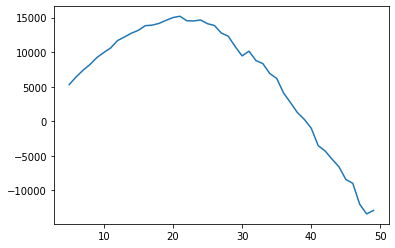

In [137]:
mean = products_stat.loc[products_stat['product']=='B']['mean']
std = products_stat.loc[products_stat['product']=='B']['std']

product_cost = products_price.loc[products_price['product']=='B']['price']
inventory_cost = product_cost

review = weekly_review('A', 5, 50,1)
xx = [i for i in review.keys()]
yy = []
for val in review.values():
    yy.append(val[0])

plt.plot(xx, yy)
plt.show()

Now it's time for the calculations. The following function prints the mean profit (revenue of sales - cost of sinventory) and the range between the 5% and 95% quartiles.

In [154]:
import operator

def plot_weekly_review(product_str, low, high, step=50):
    
    review = weekly_review(product_str, low, high, step)
    optimum = max(review.items(), key=operator.itemgetter(1))
    
    xx = [i for i in review.keys()]
    yy = []
    y_sd_1 = []
    y_sd_2 = []
    y_sd = []
    for val in review.values():
        yy.append(val[0])
        y_sd_1.append(val[1])
        y_sd_2.append(val[2])
        y_sd.append(val[3])

    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.plot(xx, yy, linewidth=2)
    plt.fill_between(xx, y_sd_1, y_sd_2, alpha=.25)
    plt.axvline(x = optimum[0], color='k', alpha = .5, ls = '--')
    plt.text(optimum[0], .5,str(optimum[0]))
    print(optimum[0])

    ax.set_ylabel('Profit')
    ax.set_xlabel('M')
    ax.set_title('Simulation of Profit')

20


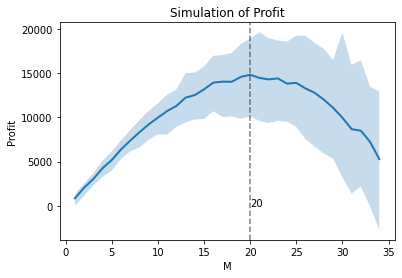

In [156]:
plot_weekly_review('A', 1, 35,1)

5


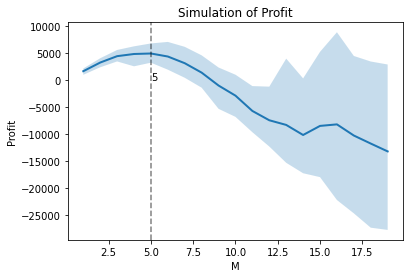

In [155]:
plot_weekly_review('B', 1, 20,1)

19


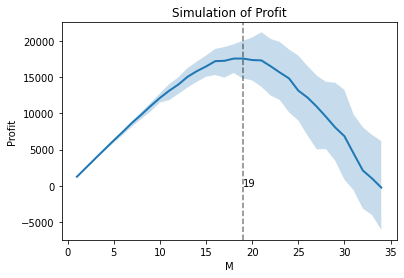

In [157]:
plot_weekly_review('C', 1, 35,1)

15


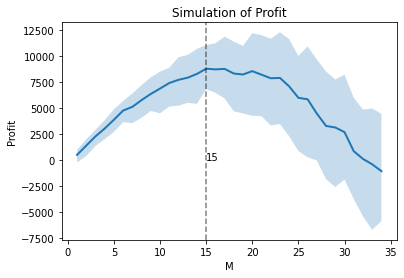

In [158]:
plot_weekly_review('D', 1, 35,1)

6


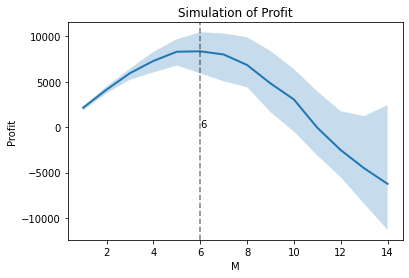

In [159]:
plot_weekly_review('E', 1, 15,1)

## Approach 3: Continous Inventory Review

In this approach, we will try to find the *M* value which dipatches the need to restock the inventory: the *M* is the reorder point.

This approach will also find the value *Q*, which means the amount of product to restock.

Both *Q* and *M* will be found using the Monte Carlo approach.


In [182]:
def cc_monte_carlo(product_str, q, r, starting_inventory = 0):
    mean = products_stat.loc[products_stat['product']==product_str]['mean']
    std = products_stat.loc[products_stat['product']==product_str]['std']

    inventory = r
    q = 0
    stock_out = 0
    counter = 0

    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    
    for day in range(1, 365):
        day_demand = np.round(np.log(np.random.lognormal(mean, std))) # Log-normal distribution
        data['daily_demand'].append(day_demand)

        if inventory <= r and not order_placed:
            # Time to place an order
            order_placed = True

        if order_placed:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

In [183]:
data = cc_monte_carlo('A', 7, 29, starting_inventory = 0)

In [161]:
def cc_mc_simulation(product_str, q, r, num_simulations=50):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo(product_str, q, r)
        # Calculating the profit
        profit = calculate_profit(data, product_str)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [171]:
def continous_review(product, q_guess, r_guess, q_range=30,r_range=30, step=1):
    
    q_low = q_guess - q_range
    q_low = 1 if q_low <= 0 else q_low
    q_high = q_guess + q_range
    q_range = [i for i in range(int(q_low), int(q_high), step)]

    r_low = r_guess - r_range
    r_low = 1 if r_low <= 0 else r_low
    r_high = r_guess + r_range
    r_range = [i for i in range(int(r_low), int(r_high), step)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

In [191]:
cc_review = continous_review('B', 10, 10)

In [192]:
max(cc_review.items(), key=operator.itemgetter(1))

((32, 39),
 (-567.7737999999999,
  -2361.975,
  728.8379999999995,
  926.4833859101631,
  0.9846375829536832))

In [189]:
cc_review2 = continous_review('A', 10, 10,20,20,2)

In [190]:
max(cc_review2.items(), key=operator.itemgetter(1)) #7,29

((1, 21),
 (-1363.4544,
  -2768.892,
  -319.8720000000003,
  706.7384076025867,
  0.9980787318678902))

In [185]:
cc_review3 = continous_review('C', 10, 10,20,20,2)

In [186]:
max(cc_review3.items(), key=operator.itemgetter(1))

((5, 29),
 (605.2578,
  324.86999999999995,
  724.7099999999999,
  138.44459999999998,
  0.9969653773471435))

In [179]:
cc_review3.items()

dict_items([((1, 1), (-41.9832, -163.68449999999999, 0.0, 65.05852655693948, 1.0)), ((1, 3), (-33.486599999999996, -177.42899999999997, 0.0, 59.05470648847559, 1.0)), ((1, 5), (-47.9808, -213.66449999999998, 0.0, 81.79635854584237, 1.0)), ((1, 7), (-49.480199999999996, -229.90799999999996, 0.0, 84.59622536472888, 1.0)), ((1, 9), (-42.483000000000004, -163.68449999999999, 0.0, 70.01661077915726, 1.0)), ((1, 11), (-38.984399999999994, -163.68449999999999, 0.0, 63.84150258758013, 1.0)), ((1, 13), (-28.9884, -124.94999999999999, 0.0, 44.524298056679115, 1.0)), ((1, 15), (-46.9812, -188.67449999999997, 0.0, 70.44166376910755, 1.0)), ((1, 17), (-65.4738, -213.66449999999998, 0.0, 82.86587536229857, 1.0)), ((1, 19), (-37.9848, -138.69449999999998, 0.0, 53.65347762223806, 1.0)), ((1, 21), (-49.97999999999999, -188.67449999999997, 0.0, 83.183298251512, 1.0)), ((1, 23), (-28.988400000000002, -152.43899999999996, 0.0, 50.318716253895026, 1.0)), ((1, 25), (-42.483000000000004, -199.92, 0.0, 70.372

## Approach 3: LTSM

In [93]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [39]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :,0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [40]:
dt_A = dt.loc[dt['product']=='A'].drop(columns=['product','week']).reset_index().drop(columns=['index'])
dt_B = dt.loc[dt['product']=='B'].drop(columns=['product','week']).reset_index().drop(columns=['index'])
dt_C = dt.loc[dt['product']=='C'].drop(columns=['product','week']).reset_index().drop(columns=['index'])
dt_D = dt.loc[dt['product']=='D'].drop(columns=['product','week']).reset_index().drop(columns=['index'])
dt_E = dt.loc[dt['product']=='E'].drop(columns=['product','week']).reset_index().drop(columns=['index'])

In [42]:
ar_A = dt_A.to_numpy()
ar_B = dt_B.to_numpy()
ar_C = dt_C.to_numpy()
ar_D = dt_D.to_numpy()
ar_E = dt_E.to_numpy()

In [44]:
dataset = np.hstack((ar_A, ar_B, ar_C,ar_D,ar_E))

In [ ]:
dataset2 = dataset.reshape((len(ar_A),-1,4))


In [48]:
n_steps = 3
X, y = split_sequences(dataset2, n_steps)

In [49]:
n_features = X.shape[2]
n_features

5

In [50]:
X2 = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]*X.shape[3]))

In [99]:
X_train , X_test = X2[0:int(X.shape[0]*0.8)] , X2[int(X.shape[0]*0.8):]
y_train, y_test = y[0:int(X.shape[0]*0.8)] , y[int(X.shape[0]*0.8):]

In [100]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,1)).reshape(X_test.shape)


In [105]:
target_scaler = MinMaxScaler(feature_range=(0,1))
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

In [106]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1],X2.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu',return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
model.add(Dense(X.shape[2]))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=400, verbose=0)

In [107]:
preds = model.predict(X_test)

In [108]:
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = MeanSquaredError()
 mae_ = MeanAbsoluteError()
 mape_ = MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)

In [109]:
evaluate_forecast(target_scaler.inverse_transform(y_test),target_scaler.inverse_transform(preds))
#evaluate_forecast(y_test,preds)
#mae: tf.Tensor(7.9079256, shape=(), dtype=float32)
#mse: tf.Tensor(207.71811, shape=(), dtype=float32)
#mape: tf.Tensor(44.77355, shape=(), dtype=float32)
#mae: tf.Tensor(7.5726614, shape=(), dtype=float32)
#mse: tf.Tensor(207.67114, shape=(), dtype=float32)
#mape: tf.Tensor(41.748688, shape=(), dtype=float32)

mae: tf.Tensor(7.6027985, shape=(), dtype=float32)
mse: tf.Tensor(210.3916, shape=(), dtype=float32)
mape: tf.Tensor(35.973286, shape=(), dtype=float32)
